# Введение в нейронные сети
### Урок 3. TensorFlow

1. Попробуйте улучшить работу нейронной сети (разобранную на уроке), обучавшейся на датасет Fashion-MNIST. Напишите в комментариях к уроку, какого результата вы добились от нейросети и что помогло улучшить её точность <br>
2. Поработайте с документацией TensorFlow 2. Попробуйте найти полезные команды TensorFlow, неразобранные на уроке <br>
3. Попробуйте обучить нейронную сеть на TensorFlow 2 на датасете imdb_reviews.

In [6]:
import keras
from keras.layers import *
import keras.utils
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

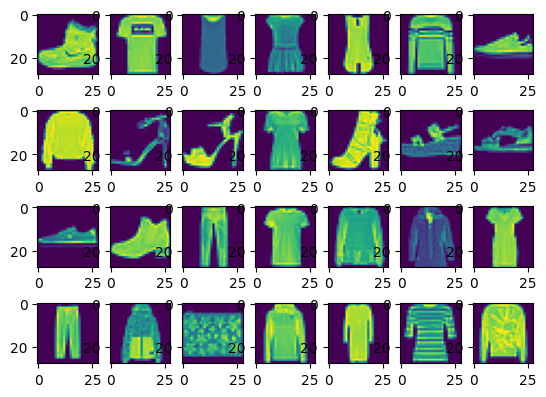

In [7]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

for i in range(28):
    plt.subplot(4,7,i+1)
    plt.imshow(x_train[i])
plt.show()

In [8]:
input_shape = (28, 28, 1)
x_train = x_train / 255
x_test = x_test / 255
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

#### Гипотеза 1 <br>
Точность модели увеличится, если увеличить кол-во батчей

Сделаем функцию для создания модели и ее компиляции

In [9]:
def create_model():
  model = keras.Sequential([
    keras.Input(shape=input_shape),
    Conv2D(32, padding = 'same', kernel_size = (3,3), activation = 'relu' ),
    MaxPooling2D( (2,2), strides = 2),
    Flatten(), # перевод в одномерный массив
    Dense(50, activation = 'relu'), # количество входных нейронов
    Dense(10, activation = 'softmax')   # количество выходных нейронов
    ] )
      
  model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

Проверим нашу модель на батчах разных размеров: возьмем пример с семинара - 32 и два батча больших размеров - 100 и 250

In [11]:
%%time
# создадим список батчей
batch_size_list = [32, 100, 250]
# пустой словарик для записи результатов
res_model = {}

# пройдемся циклом по каждому элементу списка батчей
for el in batch_size_list:

    model_el = create_model()
    # ПЕРЕД ОБУЧЕНИЕМ ДОБАВИМ ЗАЩИТУ ОТ ПЕРЕОБУЧЕНИЯ
    # если в течении 3 эпох точность не будет расти, то обучение прервется
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

    # обучаем модель на 15 эпохах, предварительные результаты не выводим, только конечный
    history = model_el.fit(x_train, y_train_cat, batch_size=el, epochs=15, validation_data =(x_test, y_test_cat), verbose=0, callbacks=[es_callback] )
    # добавляем сообщение, когда закончилось обучение
    if es_callback.stopped_epoch >=1:
        print(f'Обучение остановлено на {es_callback.stopped_epoch} эпохе')
    # оценим работу модели на тестовых данных
    test_loss, test_acc = model_el.evaluate(x_test, y_test_cat, verbose=2)
    # резбльтат модели выведем на экран
    print(f'Точность модели model_{el}: {100*test_acc:.2f} %')
    # сохраняем в словарь результаты конкретной модели (для построения диаграммы)
    res_model[f'model_{el}'] = history

Обучение остановлено на 11 эпохе
313/313 - 2s - loss: 0.3216 - accuracy: 0.9140 - 2s/epoch - 6ms/step
Точность модели model_32: 91.40 %
313/313 - 2s - loss: 0.2953 - accuracy: 0.9131 - 2s/epoch - 6ms/step
Точность модели model_100: 91.31 %
313/313 - 2s - loss: 0.2756 - accuracy: 0.9054 - 2s/epoch - 6ms/step
Точность модели model_250: 90.54 %
CPU times: total: 1h 8min 8s
Wall time: 16min 6s


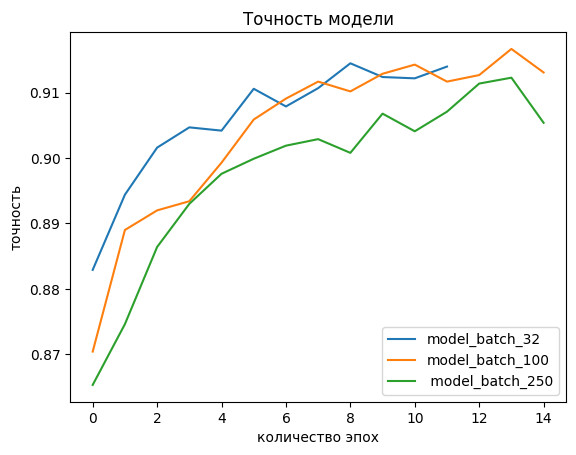

In [12]:
# загрузим данные по каждой модели
plt.plot(res_model['model_32'].history['val_accuracy'])
plt.plot(res_model['model_100'].history['val_accuracy'])
plt.plot(res_model['model_250'].history['val_accuracy'])
# название диаграммы
plt.title('Точность модели')
# ось y
plt.ylabel('точность')
# ось x
plt.xlabel('количество эпох')
# подпись графиков
plt.legend(['model_batch_32', 'model_batch_100', ' model_batch_250'], loc='lower right')
plt.show()

Обучение первой модели было остановлено на 11 эпохе: сработал созданный нами callback

**Вывод:** увеличение размера батчей до 100 немного улучшило максимальную точность нашей модели до 91,67% против 91,44% у учебной модели. Увеличение размера батчей до 250, наоборот, уменьшило точность. Для следующих тестов буду использовать 100 батчей

### Гипотеза 2 <br>
Точность модели изменится, если поменять количество фильтров

Для исследования будем использовать модели с 1 сверточным слоем на 16, 32, 64 фильтра

In [14]:
def create_model_filtres(filtres):
  model = keras.Sequential([
    keras.Input(shape=input_shape),
    Conv2D(filtres, padding = 'same', kernel_size = (3,3), activation = 'relu' ),
    MaxPooling2D( (2,2), strides = 2),
    Flatten(), # перевод в одномерный массив
    Dense(50, activation = 'relu'), # количество входных нейронов
    Dense(10, activation = 'softmax')   # количество выходных нейронов
    ] )
      
  model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [15]:
%%time

# создадим список фильтров
filtres_list = [16, 32, 64]
# для записи результатов будем использовать тот же словарик
# res_model = {}

# пройдемся циклом по каждому элементу списка батчей
for el in filtres_list:

    model_f = create_model_filtres(el)
    # ПЕРЕД ОБУЧЕНИЕМ ДОБАВИМ ЗАЩИТУ ОТ ПЕРЕОБУЧЕНИЯ
    # если в течении 3 эпох точность не будет расти, то обучение прервется
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

    # обучаем модель на 15 эпохах, предварительные результаты не выводим, только конечный
    history = model_f.fit(x_train, y_train_cat, batch_size=100, epochs=15, validation_data =(x_test, y_test_cat), verbose=0, callbacks=[es_callback] )
    # добавляем сообщение, когда закончилось обучение
    if es_callback.stopped_epoch >=1:
        print(f'Обучение остановлено на {es_callback.stopped_epoch} эпохе')
    # оценим работу модели на тестовых данных
    test_loss, test_acc = model_f.evaluate(x_test, y_test_cat, verbose=2)
    # результат модели выведем на экран
    print(f'Точность модели model_{el}_filter: {100*test_acc:.2f} %')
    # сохраняем в словарь результаты конкретной модели (для построения диаграммы)
    res_model[f'model_{el}_filter'] = history

313/313 - 2s - loss: 0.2735 - accuracy: 0.9078 - 2s/epoch - 5ms/step
Точность модели model_16_filter: 90.78 %
313/313 - 2s - loss: 0.2864 - accuracy: 0.9160 - 2s/epoch - 6ms/step
Точность модели model_32_filter: 91.60 %
Обучение остановлено на 10 эпохе
313/313 - 3s - loss: 0.2652 - accuracy: 0.9135 - 3s/epoch - 9ms/step
Точность модели model_64_filter: 91.35 %
CPU times: total: 1h 11min 26s
Wall time: 16min 34s


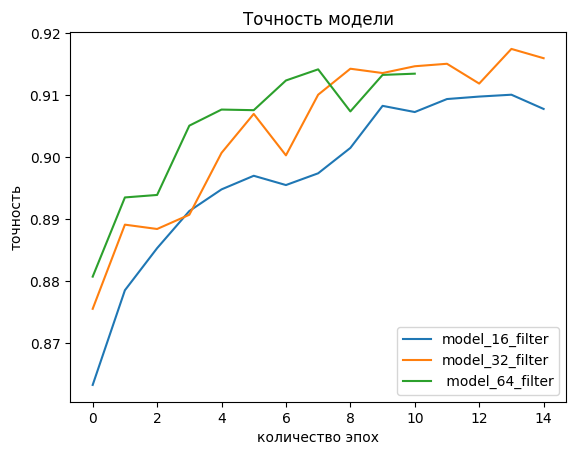

In [16]:
plt.plot(res_model['model_16_filter'].history['val_accuracy'])
plt.plot(res_model['model_32_filter'].history['val_accuracy'])
plt.plot(res_model['model_64_filter'].history['val_accuracy'])
plt.title('Точность модели')
plt.ylabel('точность')
plt.xlabel('количество эпох')
plt.legend(['model_16_filter', 'model_32_filter', ' model_64_filter'], loc='lower right')
plt.show()

Третья модель из гипотеза прервала обучение на 10 эпохе. Первая и вторая модели обучались до конца, постепенно наращивая точность.

**Вывод:** изменение количества фильтров не повлияло на точность обучения модули. Так, например, уменьшение фильтров до 16 уменьшило точность модели до 90,78 % против 91,6 % у учебной версии в 32 фильтра. Если увеличить число фильтров до 64, то точность уже будет равна 91,35 %, но это все равно ниже чем у модели с 32 фильтрами.

### Гипотеза 3 <br>
Точность модели изменится, если увеличить количество сверточных слоев

Наибольшая точность модели с 1 сверточным равна 91,6 % <br>
Протестируем модели с 2 и 3 сверточными слоями (из семинара)

In [17]:
# используем модель с двумя слоями
model_2 = keras.Sequential([
      keras.Input(shape=input_shape),
      Conv2D(32, padding = 'same', kernel_size = (3,3), activation = 'relu' ),
      MaxPooling2D( (2,2), strides = 2),
      Conv2D(64, padding = 'same', kernel_size = (3,3), activation = 'relu' ),
      MaxPooling2D( (2,2), strides = 2),
      Flatten(), # перевод в одномерный массив
      Dense(50,activation = 'relu'), # количество входных нейронов
      Dense(10, activation = 'softmax')   # количество выходных нейронов
      ] )

model_2.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [18]:
%%time

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

history_2 = model_2.fit(x_train, y_train_cat, batch_size=100, epochs=15, validation_data =(x_test, y_test_cat), verbose=1, callbacks=[es_callback] )
if es_callback.stopped_epoch >=1:
    print(f'Обучение остановлено на {es_callback.stopped_epoch} эпохе')
test_loss, test_acc = model_2.evaluate(x_test, y_test_cat, verbose=2)
print(f'Точность модели model_2: {100*test_acc:.2f} %')
res_model[f'model_2'] = history_2

Epoch 1/15
600/600 [==============================] - 53s 85ms/step - loss: 0.4906 - accuracy: 0.8258 - val_loss: 0.3656 - val_accuracy: 0.8692
Epoch 2/15
600/600 [==============================] - 48s 80ms/step - loss: 0.3154 - accuracy: 0.8882 - val_loss: 0.3154 - val_accuracy: 0.8863
Epoch 3/15
600/600 [==============================] - 48s 79ms/step - loss: 0.2723 - accuracy: 0.9023 - val_loss: 0.2803 - val_accuracy: 0.9006
Epoch 4/15
600/600 [==============================] - 45s 75ms/step - loss: 0.2440 - accuracy: 0.9132 - val_loss: 0.2820 - val_accuracy: 0.8947
Epoch 5/15
600/600 [==============================] - 45s 75ms/step - loss: 0.2200 - accuracy: 0.9204 - val_loss: 0.2751 - val_accuracy: 0.9024
Epoch 6/15
600/600 [==============================] - 45s 74ms/step - loss: 0.2027 - accuracy: 0.9271 - val_loss: 0.2476 - val_accuracy: 0.9112
Epoch 7/15
600/600 [==============================] - 44s 74ms/step - loss: 0.1874 - accuracy: 0.9318 - val_loss: 0.2377 - val_accuracy:

In [21]:
# используем модель с тремя слоями
model_3 = keras.Sequential([
      keras.Input(shape=input_shape),
      Conv2D(32, padding = 'same', kernel_size = (3,3), activation = 'relu' ),
      MaxPooling2D( (2,2), strides = 2),
      Conv2D(64, padding = 'same', kernel_size = (3,3), activation = 'relu' ),
      MaxPooling2D( (2,2), strides = 2),
      Conv2D(128, padding = 'same', kernel_size = (3,3), activation = 'relu' ),
      MaxPooling2D( (2,2), strides = 2),
      Flatten(), # перевод в одномерный массив
      Dense(50,activation = 'relu'), # количество входных нейронов
      Dense(10, activation = 'softmax')   # количество выходных нейронов
      ] )

model_3.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [22]:
%%time

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

history_3 = model_3.fit(x_train, y_train_cat, batch_size=100, epochs=15, validation_data =(x_test, y_test_cat), verbose=1, callbacks=[es_callback] )
if es_callback.stopped_epoch >=1:
    print(f'Обучение остановлено на {es_callback.stopped_epoch} эпохе')
test_loss, test_acc = model_3.evaluate(x_test, y_test_cat, verbose=2)
print(f'Точность модели model_3: {100*test_acc:.2f} %')
res_model[f'model_3'] = history_3

Epoch 1/15
600/600 [==============================] - 67s 110ms/step - loss: 0.5506 - accuracy: 0.7999 - val_loss: 0.3850 - val_accuracy: 0.8640
Epoch 2/15
600/600 [==============================] - 64s 107ms/step - loss: 0.3323 - accuracy: 0.8792 - val_loss: 0.3252 - val_accuracy: 0.8800
Epoch 3/15
600/600 [==============================] - 65s 108ms/step - loss: 0.2789 - accuracy: 0.8981 - val_loss: 0.3026 - val_accuracy: 0.8911
Epoch 4/15
600/600 [==============================] - 65s 109ms/step - loss: 0.2512 - accuracy: 0.9088 - val_loss: 0.2970 - val_accuracy: 0.8973
Epoch 5/15
600/600 [==============================] - 65s 108ms/step - loss: 0.2270 - accuracy: 0.9165 - val_loss: 0.2695 - val_accuracy: 0.9048
Epoch 6/15
600/600 [==============================] - 65s 108ms/step - loss: 0.2098 - accuracy: 0.9238 - val_loss: 0.2719 - val_accuracy: 0.9024
Epoch 7/15
600/600 [==============================] - 65s 108ms/step - loss: 0.1913 - accuracy: 0.9298 - val_loss: 0.2489 - val_ac

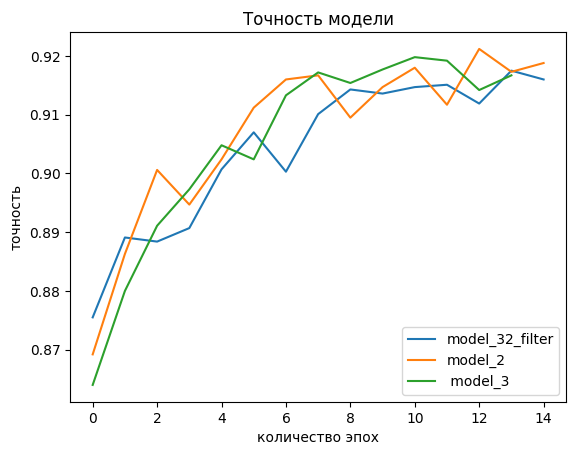

In [27]:
plt.plot(res_model['model_32_filter'].history['val_accuracy'])
plt.plot(res_model['model_2'].history['val_accuracy'])
plt.plot(res_model['model_3'].history['val_accuracy'])
plt.title('Точность модели')
plt.ylabel('точность')
plt.xlabel('количество эпох')
plt.legend(['model_32_filter', 'model_2', ' model_3'], loc='lower right')
plt.show()

**Вывод:** добавление сверточных слоев в модель увеличивает ее точность. Так у модели с двумя сверточными слоями точность составила 91,88 %, а у модели с 3 слоями она равна xx 91,67 %.
Используем модель с 2 слоями, чтобы проверить следующую гипотезу.

### Гипотеза 4 <br>
Точность модели изменится, если поменять количество фильтров в каждом слое.

Возьмем для обучения лучшую модель по количеству слоев, а именно model_2 <br>
Исследуем новые модели с разным набором фильтров

In [28]:
def create_model_2_filters(pow):
    model_2 = keras.Sequential([
        keras.Input(shape=input_shape),
        Conv2D(filters=2**pow, padding = 'same', kernel_size = (3,3), activation = 'relu' ),
        MaxPooling2D( (2,2), strides = 2),
        Conv2D(filters=2**(pow+1), padding = 'same', kernel_size = (3,3), activation = 'relu' ),
        MaxPooling2D( (2,2), strides = 2),
        Flatten(), # перевод в одномерный массив
        Dense(50,activation = 'relu'), # количество входных нейронов
        Dense(10, activation = 'softmax')   # количество выходных нейронов
        ] )

    model_2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    return model_2

Количеством фильтров обычно берется число являющееся степенем двойки. Для двух сверточных слоев возьмем пары фильтров (16,32), (32,64) и (64,128). <br> Результат пары 32,64 мы проверяли в 3 гипотезе, поэтому исследовать повторно ее не будем.

In [29]:
%%time

# создадим список фильтров. В качестве значений для первого слоя возьмем степени двойки
#pow_filtres_list = [[16,32], [64,128]]
pow_filtres_list = [4, 6]
# для записи результатов будем использовать тот же словарик
# res_model = {}

# пройдемся циклом по каждому элементу списка батчей
for el in pow_filtres_list:

    model_2f = create_model_2_filters(el)
    # ПЕРЕД ОБУЧЕНИЕМ ДОБАВИМ ЗАЩИТУ ОТ ПЕРЕОБУЧЕНИЯ
    # если в течении 3 эпох точность не будет расти, то обучение прервется
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

    # обучаем модель на 10 эпохах, предварительные результаты не выводим, только конечный
    history = model_2f.fit(x_train, y_train_cat, batch_size=100, epochs=10, validation_data =(x_test, y_test_cat), verbose=0, callbacks=[es_callback] )
    # добавляем сообщение, когда закончилось обучение
    if es_callback.stopped_epoch >=1:
        print(f'Обучение остановлено на {es_callback.stopped_epoch} эпохе')
    # оценим работу модели на тестовых данных
    test_loss, test_acc = model_2f.evaluate(x_test, y_test_cat, verbose=2)
    # результат модели выведем на экран
    print(f'Точность модели model_2_{el}pow_filter: {100*test_acc:.2f} %')
    # сохраняем в словарь результаты конкретной модели (для построения диаграммы)
    res_model[f'model_2_{el}pow_filter'] = history

313/313 - 2s - loss: 0.2534 - accuracy: 0.9091 - 2s/epoch - 7ms/step
Точность модели model_2_4pow_filter: 90.91 %
313/313 - 6s - loss: 0.2392 - accuracy: 0.9202 - 6s/epoch - 18ms/step
Точность модели model_2_6pow_filter: 92.02 %
CPU times: total: 1h 57min 31s
Wall time: 22min 10s


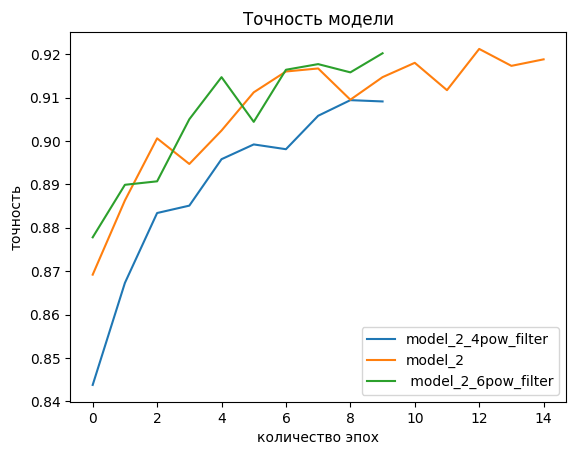

In [30]:
plt.plot(res_model['model_2_4pow_filter'].history['val_accuracy'])
plt.plot(res_model['model_2'].history['val_accuracy'])
plt.plot(res_model['model_2_6pow_filter'].history['val_accuracy'])
plt.title('Точность модели')
plt.ylabel('точность')
plt.xlabel('количество эпох')
plt.legend(['model_2_4pow_filter', 'model_2', ' model_2_6pow_filter'], loc='lower right')
plt.show()

**Вывод:** изменение фильтров в сверточных слоях нейросети еще немного улучшило ее точность

**Общий вывод:** лучшей из всех исследований показала себя модель с двумя сверточными слоями по 64 и 128 фильтров в каждом. <br>
Выводы могут быть поспешными, тк я не работал с изменением размеров квадратов ядра и объединения, а также не менял полносвязанные слои и количество нейронов в них